In [79]:
import pandas as pd
import pathlib
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
path_to_lowd_samples = "/datassd/hieunho/deconvolution_atlas_201023/201023_cfDNA_lowdepth"
import numpy as np
metadata = pd.read_excel('/datassd/hieunguyen/ECD/tumor_atlas_official/New Metadata for pan-cancer paper 2.xlsx')
metadata = metadata[metadata["Label"].isna() == False]

In [2]:
metadata.head()

,Group,Label,SampleID,Age,Gender,Tumor Stage,Tumor type,Background lesions,Unnamed: 8,Unnamed: 9,RUNTM,RUNGW
1,Discovery,Control,K0001,54.0,Female,NaN,NaN,NaN,NaN,NaN,R1718,R1718
2,Discovery,Control,K0002R1,44.0,Female,NaN,NaN,NaN,NaN,NaN,R1808,R1808
3,Discovery,Control,K0003,41.0,Male,NaN,NaN,NaN,NaN,NaN,R1718,R1718
4,Discovery,Control,K0004,46.0,Female,NaN,NaN,NaN,NaN,NaN,R1718,R1718
5,Discovery,Control,K0006,61.0,Female,NaN,NaN,NaN,NaN,NaN,R1718,R1718


In [116]:
df.groupby(["Label"]).count()

TOO,index,Liver,Breast,Gastric,Lung,CRC,WBC,prediction,group,check
Label,,,,,,,,,,
Breast cancer,223,223,223,223,223,223,223,223,223,223
CRC cancer,159,159,159,159,159,159,159,159,159,159
Control,1550,1550,1550,1550,1550,1550,1550,1550,1550,1550
Gastric cancer,98,98,98,98,98,98,98,98,98,98
Liver cancer,122,122,122,122,122,122,122,122,122,122
Lung cancer,136,136,136,136,136,136,136,136,136,136


In [3]:
files = [item for item in pathlib.Path(path_to_lowd_samples).glob("*.deconvo.csv")]

In [4]:
df = pd.DataFrame(data = ["Liver", "Breast", "Gastric", "Lung", "CRC", "WBC"], columns = ["TOO"])
for file in tqdm(files):
    tmpdf = pd.read_csv(file, index_col = [0])
    df = df.merge(tmpdf, right_on = "TOO", left_on = "TOO")

df = df.set_index("TOO").T

100%|███████████████████████████████████████| 2288/2288 [01:15<00:00, 30.35it/s]


In [5]:
df = df.reset_index()

In [11]:
df["prediction"] = df[["Liver", "Breast", "Gastric", "Lung", "CRC"]].apply(
    lambda x: ["Liver", "Breast", "Gastric", "Lung", "CRC"][list(x).index(max(x))]  + " cancer", axis = 1
)

In [12]:
df["Label"] = df["index"].apply(lambda x: metadata[metadata["SampleID"] == x.split(".")[0]].Label.unique()[0])

In [13]:
df["group"] = df["index"].apply(lambda x: metadata[metadata["SampleID"] == x.split(".")[0]].Group.unique()[0])

In [27]:
df["check"] = df[["prediction", "Label"]].apply(lambda x: "correct" if x[0] == x[1] else "incorrect", axis = 1)

In [28]:
df.groupby(["group", "check"])["index"].count()

group       check    
Discovery   correct       125
            incorrect    1450
Validation  correct        68
            incorrect     645
Name: index, dtype: int64

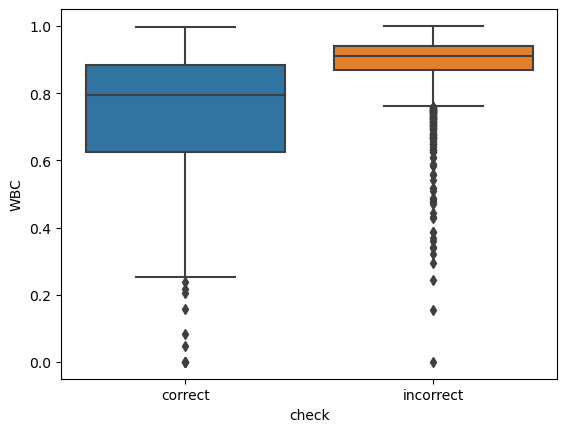

In [29]:
sns.boxplot(data = df, x = "check", y = "WBC")
plt.show()

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Breast cancer'),
  Text(1, 0, 'Gastric cancer'),
  Text(2, 0, 'Lung cancer'),
  Text(3, 0, 'CRC cancer'),
  Text(4, 0, 'Liver cancer'),
  Text(5, 0, 'Control')])

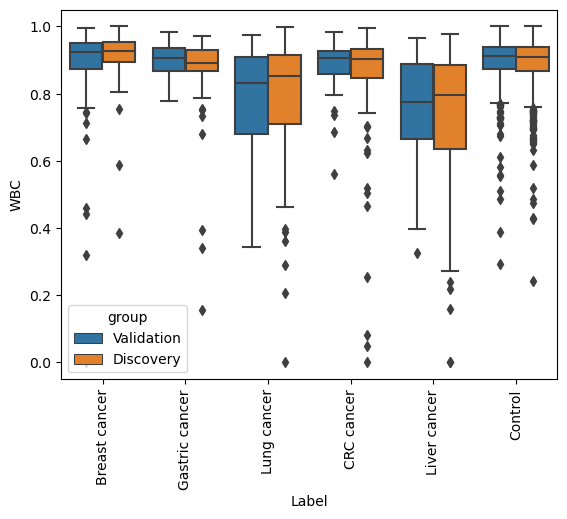

In [112]:
sns.boxplot(data = df, x = "Label", y = "WBC", hue  = "group")
plt.xticks(rotation = 90)

In [70]:
df_discovery = df[(df["Label"] != "Control") & (df["group"] == "Discovery")]
df_validation = df[(df["Label"] != "Control") & (df["group"] == "Validation")]

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

convert = dict()
convert["Liver cancer"] = 0
convert["Breast cancer"] = 1
convert["Gastric cancer"] = 2
convert["Lung cancer"] = 3
convert["CRC cancer"] = 4

convert_back = dict()
convert_back[0] = "Liver cancer"
convert_back[1] = "Breast cancer"
convert_back[2] = "Gastric cancer"
convert_back[3] = "Lung cancer"
convert_back[4] = "CRC cancer"

In [57]:
X_train = df_discovery[["Liver", "Breast", "Gastric", "Lung", "CRC"]].to_numpy()
X_test = df_validation[["Liver", "Breast", "Gastric", "Lung", "CRC"]].to_numpy()
y_train = [convert[item] for item in df_discovery["Label"].to_list()]
y_test = [convert[item] for item in df_validation["Label"].to_list()]
bst = XGBClassifier(n_estimators=10, max_depth=200, learning_rate=0.001, objective='multi:softmax')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
accuracy_score(preds, y_test)

0.3263598326359833

In [117]:
accuracy_score(bst.predict(X_train), y_train)

0.779559118236473

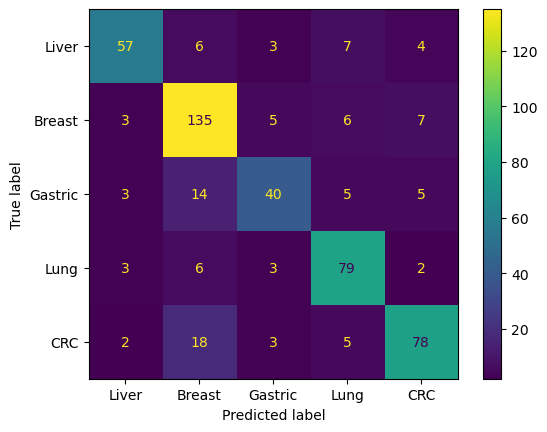

In [118]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, bst.predict(X_train)), display_labels=["Liver", "Breast", "Gastric", "Lung", "CRC"])
disp.plot()

In [106]:
cm = confusion_matrix(y_test, preds)

pct_cm = cm.diagonal()/np.sum(cm, axis = 1)

In [110]:
np.sum(cm, axis = 1)

array([45, 67, 31, 43, 53])

In [109]:
pct_cm

array([0.31111111, 0.49253731, 0.03225806, 0.18604651, 0.41509434])

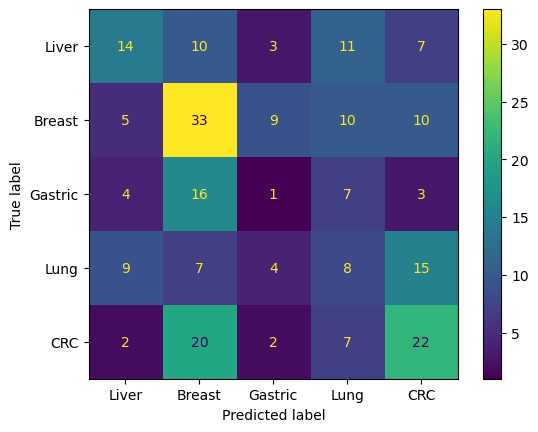

In [77]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Liver", "Breast", "Gastric", "Lung", "CRC"])
disp.plot()

In [71]:
df_validation["XGBoost_pred"] = [convert_back[item] for item in preds]

/tmp/ipykernel_476589/3259451529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation["XGBoost_pred"] = [convert_back[item] for item in preds]


In [74]:
df_validation["check_XGBoost"] = df_validation[["XGBoost_pred", "Label"]].apply(lambda x: "correct" if x[0] == x[1] else "incorrect", axis = 1)

/tmp/ipykernel_476589/2676380499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation["check_XGBoost"] = df_validation[["XGBoost_pred", "Label"]].apply(lambda x: "correct" if x[0] == x[1] else "incorrect", axis = 1)


In [75]:
df_validation.groupby(["check_XGBoost", "Label"])["index"].count()

check_XGBoost  Label         
correct        Breast cancer     33
               CRC cancer        22
               Gastric cancer     1
               Liver cancer      14
               Lung cancer        8
incorrect      Breast cancer     34
               CRC cancer        31
               Gastric cancer    30
               Liver cancer      31
               Lung cancer       35
Name: index, dtype: int64